# Week 2: Supervised Learning for Classification Applications

For this assignment, you are a Machine Learning Engineer at a financial institution working to improve the effectiveness of their marketing department.

The dataset comes from the UCI repository and is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to asseess if the product (bank term deposit) would be (‘yes’) or not (‘no’) subscribed.

We'll discuss a few topics with respect to this use case:

I. Data wrangling to perform one-hot-encoding for the data and normalization

II. Performing classification to bank term deposit subscription

III. Using Classification Thresholds to Optimize Business Decisions 

### Import the necessary modules

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the training data. Print out its shape and first few rows.

In [ ]:
url = "https://raw.githubusercontent.com/FourthBrain/2.-Classification/main/bank-full.csv?token=ARJV76TWTYENKFZKXB4CUYS7SIDOM"
df_train = pd.read_csv(url, sep=';')
print(df_train.shape)
df_train.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Exercise: Perform Exploratory Data Analysis on each feature

In [ ]:
### START CODE HERE ###
# Get the info (column number and name, non-null count, and dtype) for each column in the training df
df_train.info()
# Get summary statistics for the training df with the describe() method
df_train.describe()
### END CODE HERE ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
df_train.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


### Exercise: Visualize the distributions of each numeric feature

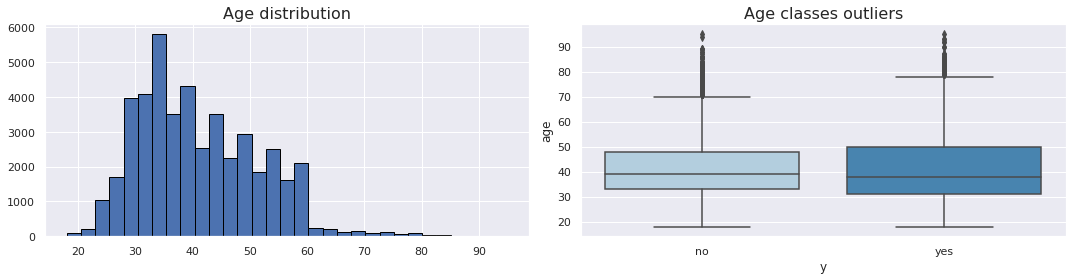

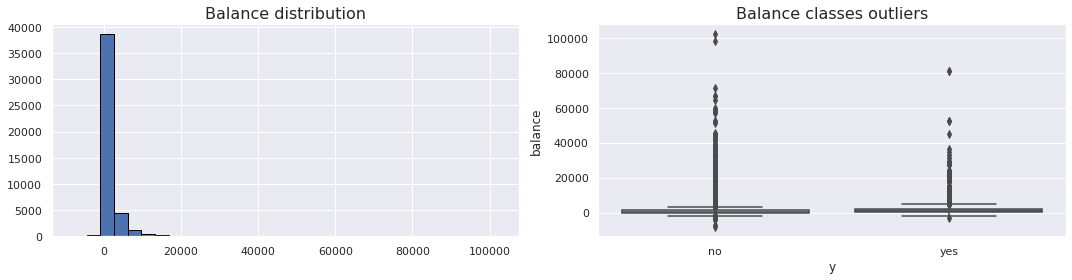

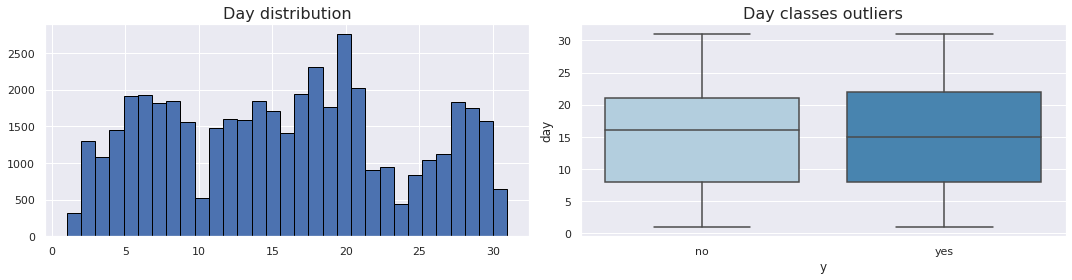

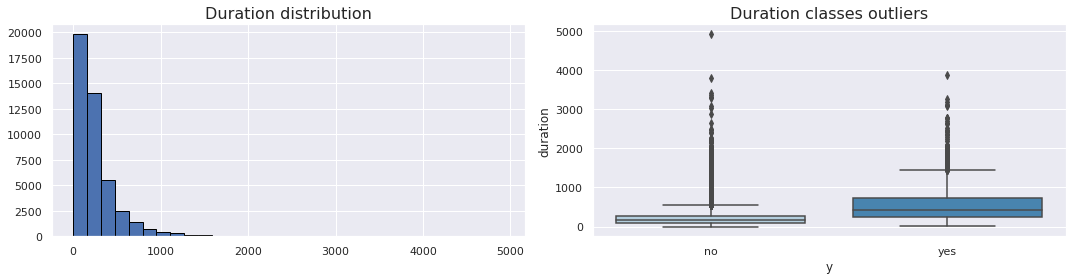

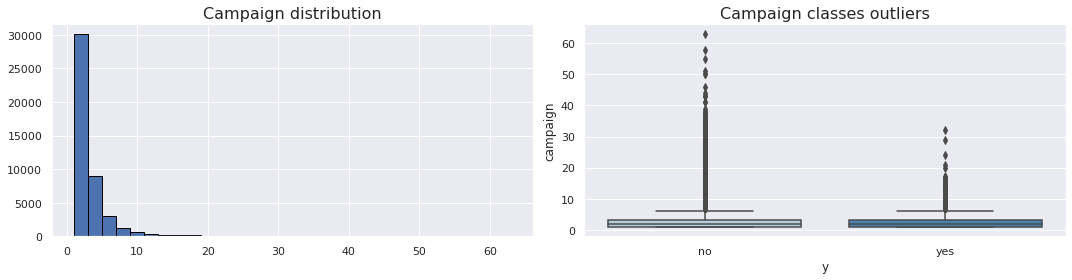

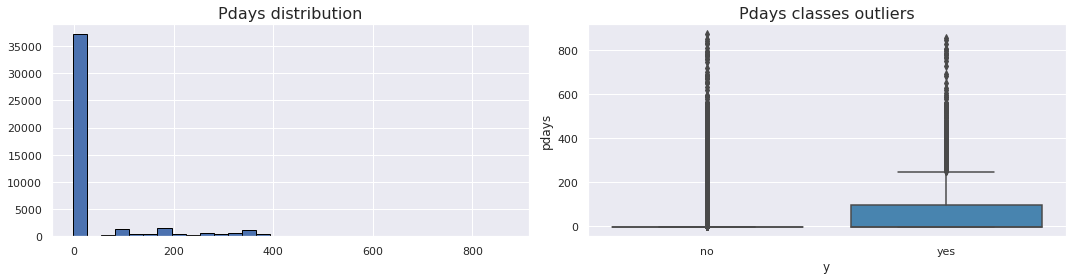

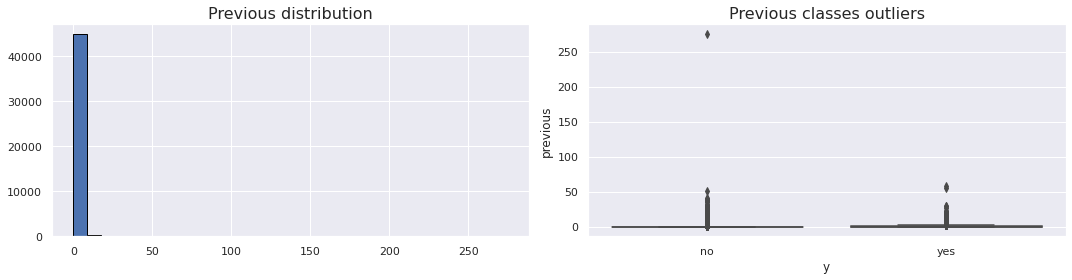

In [ ]:
numeric_columns = [col for col in df_train.columns if df_train[col].dtype == int]

for col in numeric_columns:
    # setting for multiple graphs
    fig, axs =  plt.subplots(nrows=1, ncols=2, figsize = (15,4))
    axs = axs.reshape(-1)
    
    # plotting the gerneral histogram
    axs[0].hist(df_train[col], bins=31, edgecolor = 'black')
    axs[0].set_title(col.title() + ' distribution', fontsize=16)
    
    # plotting box plot
    sns.boxplot(data=df_train, y=col, x='y', ax=axs[1], palette = 'Blues')
    axs[1].set_title(col.title() + ' classes outliers', fontsize=16)
    
    plt.tight_layout()

### Exercise: Inspect the unique values of the non-numeric columns, and their counts

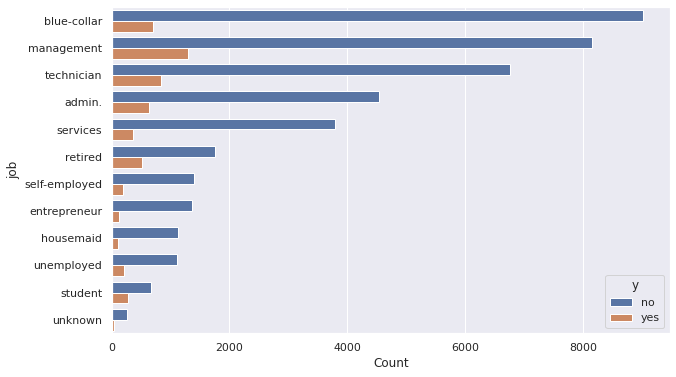

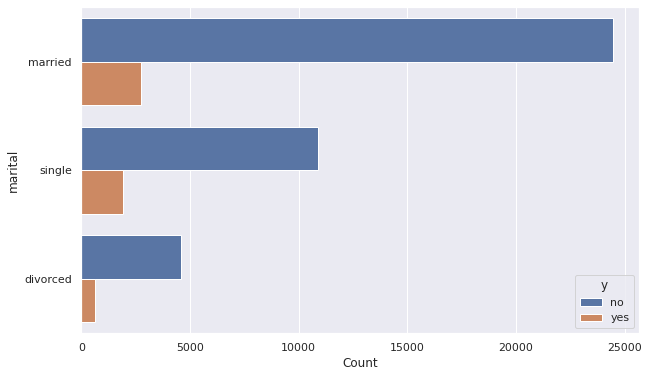

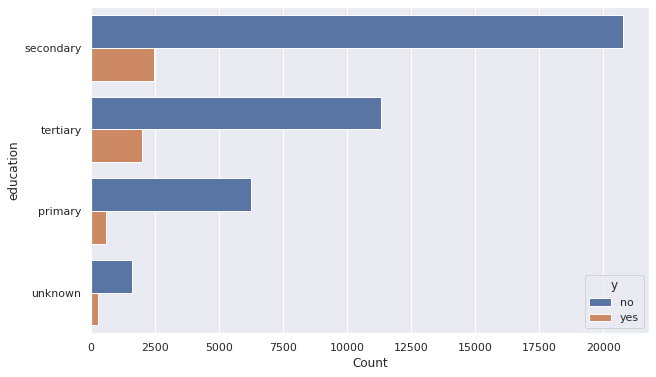

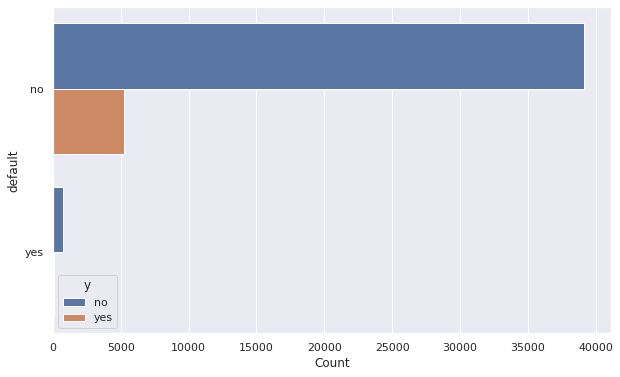

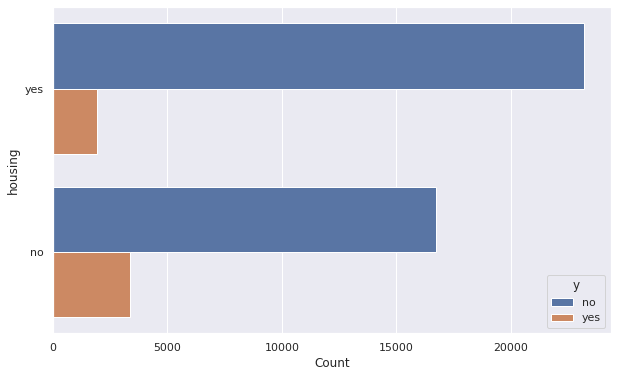

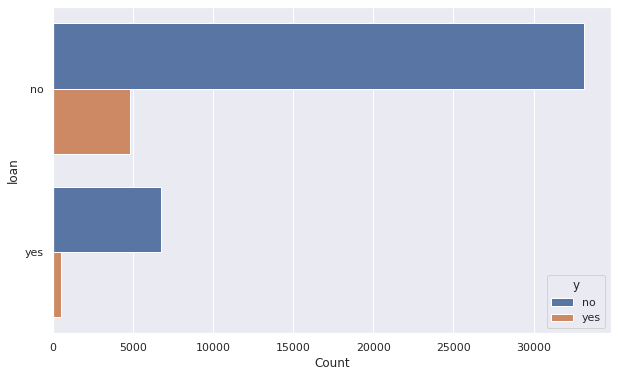

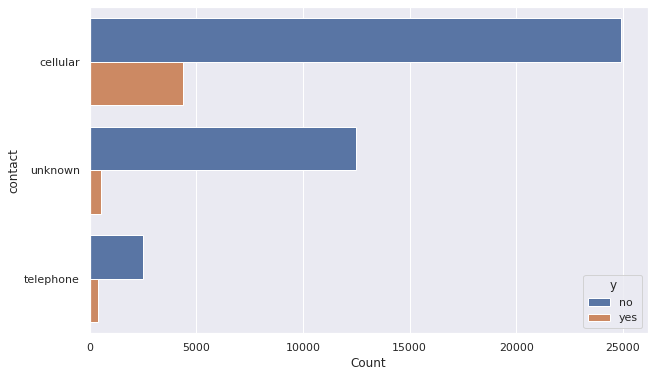

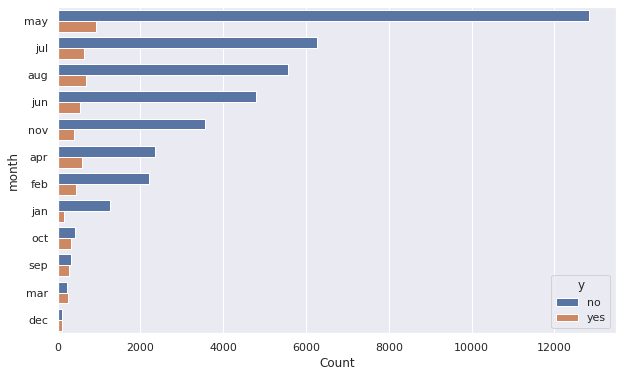

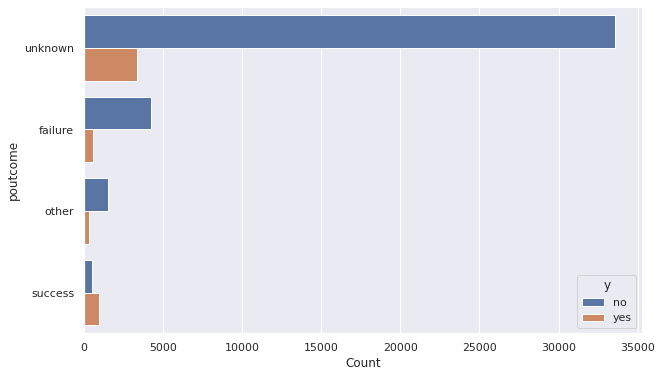

In [ ]:
### START CODE HERE ###
# Use a list comprehension to list the names of the non-numeric columns in the training df
# (those with an object dtype)
non_numeric_columns = [col for col in df_train.columns if col not in numeric_columns and col != 'y']
# Loop through the non-numeric columns
for col in non_numeric_columns:
  plt.figure(figsize=(10,6))  
  dfg = df_train.groupby(['y'])[col].value_counts().reset_index(name='Count')
  sns.barplot(y=col, x='Count', data=dfg, hue='y', orient='h')
### END CODE HERE ###

### Exercise: Some columns are 'yes'/'no' binaries. Map them to integer binaries.

In [ ]:
### START CODE HERE ###
# Make a list of the binary columns. There should be 4 of them. 
# Find their names in the output of the previous exercise.
binary_columns = ['default', 'housing', 'loan', 'y']
# Create a dictionary in which the keys map to the values
# Remember, we want to replace 'no' and 'yes' with the appropriate integers
binary_mapping = {'no': 0, 'yes': 1}
# Map the binary columns
for col in binary_columns:
    # Apply the mapping to the current column with the map() method for Pandas Series
    df_train[col] = df_train[col].map(binary_mapping)
### END CODE HERE ###

### Exericse: Map the months from strings to integers, with 1 corresponding to January, etc.

In [ ]:
### START CODE HERE ###
# Create the mapping dictionary
# Make sure the months' names are formatted properly
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
# Map the months
df_train['month'] = df_train['month'].map(month_mapping)
### END CODE HERE ###

### Exercise: One-hot encode the remaining categorical features

In [ ]:
### START CODE HERE ###
# List the categorical features. There should be 5 of them.
categorical_columns = ['job', 'marital', 'education', 'contact', 'poutcome']
# One-hot encode the categorical features with the get_dummies() function for Pandas DataFrames
df_train = pd.get_dummies(df_train, columns=categorical_columns)
### E3ND CODE HERE ###

### Inspect the first few rows of our preprocessed DataFrame

In [ ]:
print(df_train.shape)
df_train.head()

(45211, 38)


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


### Exercise: Inspect how balanced y is

For a balanced binary target, approximately half of its entries will be 1

In [ ]:
### START CODE HERE ###
# Compute the fraction of positive values in the target
df_train['y'].value_counts(normalize=True)
### END CODE HERE ###

0    0.883015
1    0.116985
Name: y, dtype: float64

### Exercise: Extract the target values from the training DataFrame

In [ ]:
### START CODE HERE ###
# Extract the target values from the training DataFrame
y = df_train['y']
# Drop the target column from the training DataFrame
X = df_train.drop(columns='y')
print(X.shape)
### END CODE HERE ###

(45211, 37)


### Exercise: Visually inspect the Pearson Correlations of each feature

Pandas provides the `corr()` method for DataFrames for this purpose

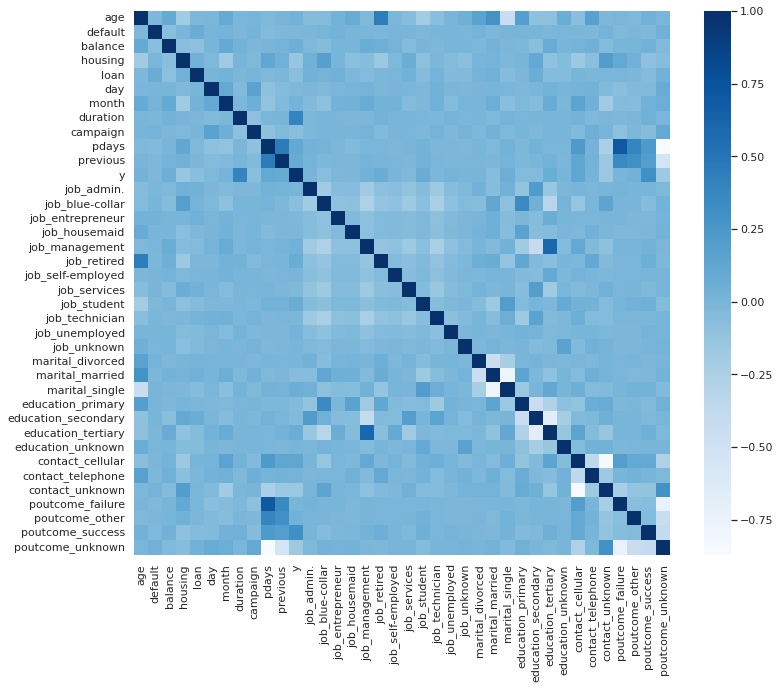

In [ ]:
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the training df
cor = df_train.corr()
### END CODE HERE ###
# Plot the correlations
sns.heatmap(cor, cmap='Blues')
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

## Feature Selection

### Exercise: Drop feature columns which have a high absolute Pearson Correlation

Let's choose to drop the higher-indexed of the two correlated columns, i.e. the one that appears farther to the right in the df

In [ ]:
### START CODE HERE ### 
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
### END CODE HERE ###

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 10))

Top Absolute Correlations
pdays                poutcome_unknown      0.869962
contact_cellular     contact_unknown       0.862398
marital_married      marital_single        0.772357
poutcome_failure     poutcome_unknown      0.737932
pdays                poutcome_failure      0.701052
education_secondary  education_tertiary    0.662890
job_management       education_tertiary    0.598900
previous             poutcome_unknown      0.532763
pdays                previous              0.454820
age                  job_retired           0.447378
dtype: float64


Leaving all features for this exercise, but in a real project maybe drop highly correlated variables. Threshold: 0.7. But this is more important in a linear model than in a gradient boosting model.

## Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape)

(36168, 37) (9043, 37)


In [ ]:
y_train.sum() / len(y_train)

0.11698186241981863

In [ ]:
y_test.sum() / len(y_test)

0.11699657193409267

## Random Forest Classification

### Exercise: Default Random Forest Classifier

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

### START CODE HERE ###
# Instantiate the classifier
# Set the random state to 0
clf = RandomForestClassifier(random_state=0)
#clf = RandomForestClassifier(random_state=0, max_depth=10, class_weight='balance')
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
y_test_pred = clf.predict(X_test)
# Compute the confusion matrix between the true and predicted test targets
cm = confusion_matrix(y_test, y_test_pred)
# Compute the model's accuracy by summing the diagonals of the confusion matrix
# (i.e. taking its trace) and dividing by the number of test samples
accuracy = cm.trace()/y_test.shape[0]
### END CODE HERE ###
print(f"Accuracy = {accuracy}")
recall_scores = cross_val_score(clf, X_test, y_test, scoring='recall', cv=5)
f1_scores = cross_val_score(clf, X_test, y_test, scoring='f1', cv=5)
print(f'Mean Recall = {np.mean(recall_scores):.3f}')
print(f'Mean F1 Score = {np.mean(f1_scores):.3f}')

Accuracy = 0.9035718235098972
Mean Recall = 0.279
Mean F1 Score = 0.384


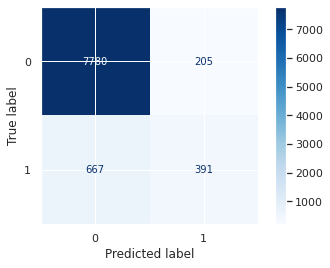

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Blues');

In [ ]:
from sklearn.metrics import classification_report

# Default RandomForestClassifier
print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      8447
           1       0.37      0.66      0.47       596

    accuracy                           0.90      9043
   macro avg       0.67      0.79      0.71      9043
weighted avg       0.93      0.90      0.92      9043



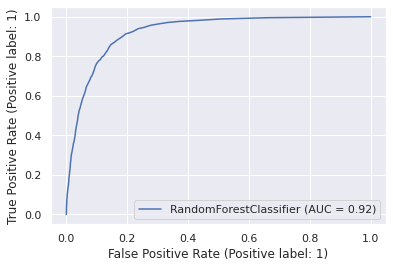

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test);

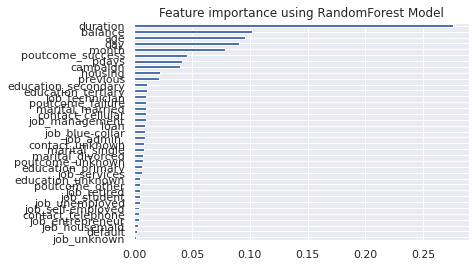

In [ ]:
imp_rf = pd.Series(clf.feature_importances_, X_train.columns.values)
imp_rf.sort_values().plot(kind = "barh")
plt.title("Feature importance using RandomForest Model");

## Exercise: Using Classification Thresholds to Optimize Business Decisions 

Source code for this section of the notebook can be found here: https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415

In [ ]:
clf.predict_proba([X_test.iloc[1]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[0.99, 0.01]])

In [ ]:
clf.classes_

array([0, 1])

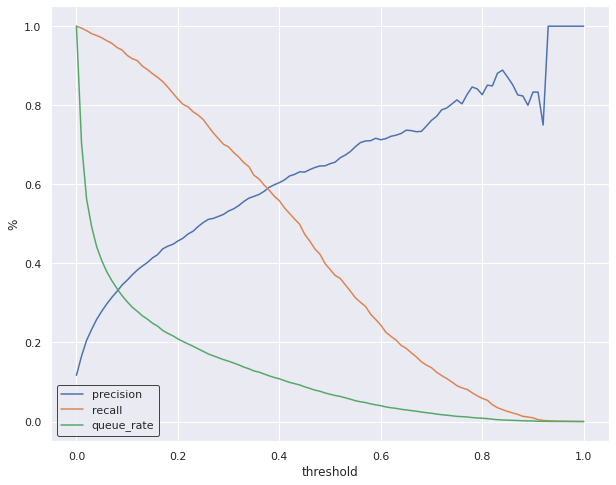

In [ ]:
from sklearn.metrics import precision_recall_curve

predictions = clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
thresholds = np.append(thresholds, 1)

queue_rate = []
for threshold in thresholds:
    queue_rate.append((predictions >= threshold).mean())
    
plt.figure(figsize=(10,8))
plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1])
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%');

In [ ]:
clf = RandomForestClassifier(oob_score=True)

n_trials = 50
test_size_percent = 0.2

plot_data = []

for trial in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_percent)
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)
    thresholds = np.append(thresholds, 1)
    
    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())
            
    plot_data.append({
        'thresholds': thresholds,
        'precision': precision,
        'recall': recall,
        'queue_rate': queue_rate
    })  

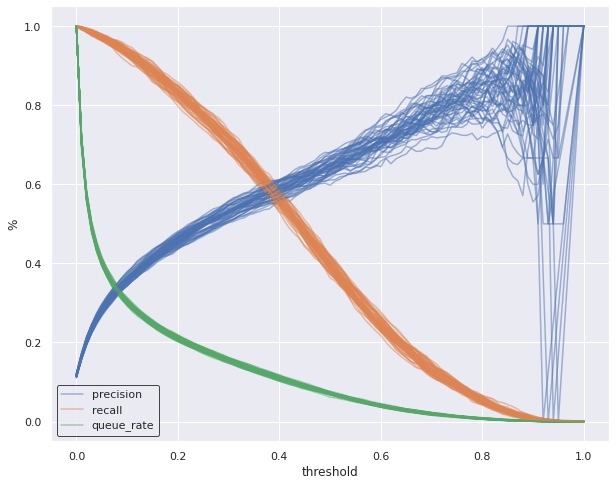

In [ ]:
plt.figure(figsize=(10,8))
for p in plot_data:
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)
    
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%');

In [ ]:
import bisect

uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []
uniform_recall_plots= []
uniform_queue_rate_plots= []

for p in plot_data:
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])
        
    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

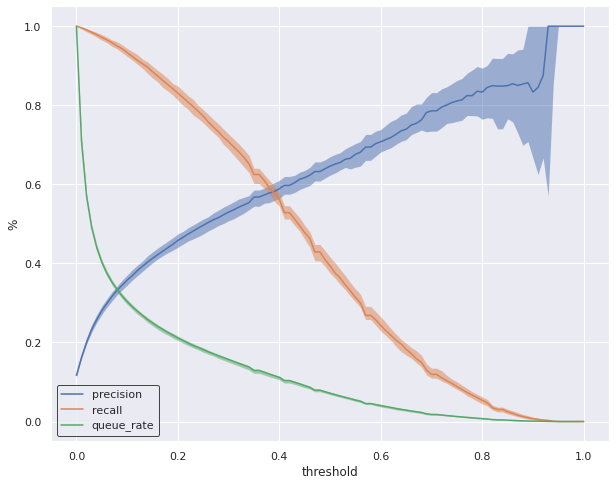

In [ ]:
from scipy.stats import mstats

quantiles = [0.1, 0.5, 0.9]
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.figure(figsize=(10,8))
plt.plot(uniform_thresholds, median_precision)
plt.plot(uniform_thresholds, median_recall)
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%');

In [ ]:
X.shape

(45211, 37)

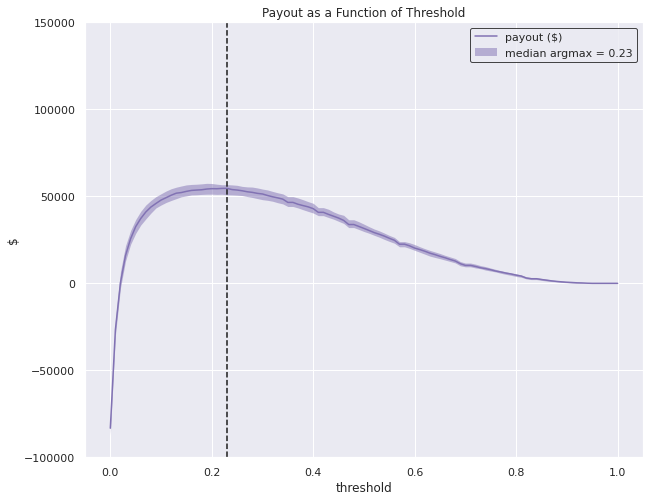

In [ ]:
uniform_thresholds = np.linspace(0, 1, 101)
uniform_payout_plots = []

n = 10000
success_payoff = 100
case_cost = 20

for p in plot_data:
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.figure(figsize=(10,8))
plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]
plt.vlines([max_ap], -100000, 150000, linestyles='--')
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.title("Payout as a Function of Threshold")
plt.ylabel('$');